> [English Version](../docs/chapter02_email_classifier.md)


> @author g.mano

# Классификатор Спама

Прежде чем применить техники отравления данных, необходимо сначала создать рабочую модель. В этом разделе мы объясним, как построить эту модель, которая послужит основой для экспериментов с отравлением данных.

Хотя начальный набор данных, используемый в этом примере, — это `spam_ham_dataset.csv`, этот подход гибкий. Вы можете создать отравленные наборы данных, переобучить модель и протестировать ее уязвимость, просто изменив имя файла на новое, указывающее на отравленный набор данных. Это позволяет проверять производительность модели при различных условиях, включая атаки, такие как изменение меток или целенаправленное отравление.

Давайте начнем!

## 1. Загрузка данных

На первом этапе мы подготавливаем окружение для загрузки данных. Это включает в себя импорт необходимых библиотек и загрузку набора данных из указанного файла.

In [49]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Модуль `os` важен, поскольку мы будем работать с локальными скриптами для обработки и очистки данных. Имена файлов наборов данных задаются как переменные, и мы загружаем набор данных в зависимости от выбранного имени файла.

In [50]:
import sys
import os

# Add the parent directory to sys.path
sys.path.append(os.path.abspath(os.path.join('..')))

Чтобы загрузить нужный набор данных, просто раскомментируйте строку, соответствующую нужному файлу:

- `spam_ham_dataset.csv` — для исходного набора данных
- `spam_ham_dataset_targeted.csv` — для целенаправленного отравленного набора данных
- `spam_ham_dataset_poisoned.csv` — для набора данных с отравлением

После этого набор данных будет загружен, очищен и подготовлен для обучения модели.

In [51]:
from modules.load_dataset import load_dataset
#filename='spam_ham_dataset.csv'
#filename='spam_ham_dataset_targeted.csv' 
filename='spam_ham_dataset_poisoned.csv'

spambase=load_dataset(filename)
spambase.head()

,Unnamed: 0,label,text,label_num
0,2996,spam,"Subject: enron actuals for april 4 , 2001\r\ne...",1
1,2714,spam,Subject: new contact for devon\r\nplease note ...,1
2,1361,spam,Subject: revised noms - gathering contracts\r\...,1
3,1866,spam,Subject: revised : eastrans nomination change ...,1
4,333,spam,Subject: cilco pathing - withdrawl and hplc tr...,1


## 2. Анализ данных
Перед тем как начать обработку данных, нужно получить представление о его структуре. Важной частью этого процесса является анализ распределения меток — сколько в наборе данных писем `spam`, а сколько — `ham` (не спам).

На этом этапе мы генерируем круговую диаграмму, чтобы визуализировать пропорцию `spam` и `ham` писем. Это поможет понять, если данные несбалансированы, что важно, поскольку несбалансированные наборы данных могут отрицательно сказаться на способности модели обобщать новые данные.

Например, если в наборе данных значительно больше писем `ham`, чем `spam`, возможно, потребуется применить такие техники, как перераспределение данных (например, увеличение меньшинства через oversampling или уменьшение большинства через undersampling).

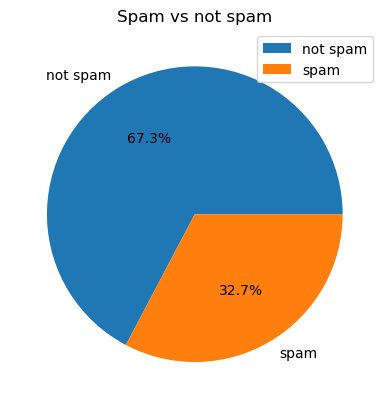

In [52]:
plt.pie(spambase['label_num'].value_counts(),labels=['not spam','spam'], autopct='%1.1f%%')
plt.title('Spam vs not spam')
plt.legend()
plt.show()

## 3. Обработка данных

Обработка данных — это критически важный шаг для подготовки набора данных к обучению. Он включает несколько этапов, чтобы гарантировать, что данные очищены и находятся в подходящем формате для машинного обучения.

### - Проверка на отсутствие данных

Первым шагом является проверка на наличие пропущенных или пустых значений в наборе данных. Пропущенные данные могут привести к некорректным предсказаниям, поэтому их нужно обработать соответствующим образом. Если пропущенные значения найдены, их можно либо удалить, либо заменить на запасные значения (в зависимости от ситуации).

In [53]:
spambase.isna().sum()

Unnamed: 0    0
label         0
text          0
label_num     0
dtype: int64

### - Очистка данных

Следующим шагом является очистка текстовых данных. Для этого был создан специальный класс `CleanText`, который выполняет следующие операции с текстовыми данными:

- **Удаление стоп-слов**: Слово "the", "and", "is" и другие, которые не несут полезной информации для задачи классификации.
- **Удаление знаков препинания и специальных символов**: Текст часто содержит ненужные знаки препинания, которые удаляются для очищения данных.
- **Удаление пустых или неверных записей**: Все пустые или неактуальные записи удаляются.

Однако **ссылки не удаляются**, поскольку они могут содержать важную информацию (например, ссылки на фишинговые сайты или другие индикаторы спама), что может улучшить производительность модели.

In [54]:
from modules.clean_text import CleanText

cleaner = CleanText()
spambase["text_cleaned"] = spambase["text"].apply(cleaner.on_clean)
spambase.head()

,Unnamed: 0,label,text,label_num,text_cleaned
0,2996,spam,"Subject: enron actuals for april 4 , 2001\r\ne...",1,"subject enron actuals april 4 , 2001 estimated..."
1,2714,spam,Subject: new contact for devon\r\nplease note ...,1,subject new contact devon please note leaving ...
2,1361,spam,Subject: revised noms - gathering contracts\r\...,1,subject revised noms gathering contracts dave ...
3,1866,spam,Subject: revised : eastrans nomination change ...,1,subject revised eastrans nomination change eff...
4,333,spam,Subject: cilco pathing - withdrawl and hplc tr...,1,subject cilco pathing withdrawl hplc transport...


## 4. Выбор признаков

После того как данные были очищены и обработаны, следующим шагом будет выбор признаков. Выбор признаков — это процесс определения наиболее значимых признаков (в нашем случае, слов или n-грамм), которые модель будет использовать для предсказания.

Для текстовых данных признаки обычно представляют собой слова или последовательности слов, которые часто встречаются в спамовых и не-спамовых письмах. Мы выбираем подмножество наиболее информативных признаков, что помогает улучшить производительность модели и уменьшить вычислительную сложность.

In [55]:
from sklearn.model_selection import train_test_split
X= spambase['text_cleaned']
y =spambase['label'].map({'ham':0,'spam':1})
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)
y.value_counts()

label
0    3827
1    1861
Name: count, dtype: int64

## 5. Векторизация

Модели машинного обучения требуют числовых данных для предсказания, однако текстовые данные по своей природе нечисловые. Поэтому нам нужно преобразовать текст в числовой формат с помощью **векторизации**.

На этом этапе мы используем метод **TF-IDF (Term Frequency-Inverse Document Frequency)** для векторизации. Этот метод преобразует текстовые данные в числовые векторы, учитывая как частоту слов в документе, так и то, насколько часто эти слова встречаются во всем наборе данных.

Метод **TF-IDF** позволяет взвешивать слова, которые часто встречаются в документе, но редки в других документах, делая их более важными, что помогает модели сосредоточиться на словах, которые скорее всего помогут различить спам от не-спама.

In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=6000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

## 6. Обучение модели

Теперь, когда данные очищены, обработаны и векторизованы, можно приступать к обучению моделей машинного обучения. В этом разделе мы экспериментируем с двумя моделями: **Multinomial Naive Bayes (MultinomialNB)** и **Logistic Regression**.

### - MultinomialNB

**Multinomial Naive Bayes** — это широко используемый алгоритм для задач классификации текста, особенно когда признаками являются частоты слов. Он основан на теореме Байеса и предполагает, что признаки (слова) условно независимы, если известно значение метки класса. Это делает его простым, но эффективным вариантом для классификации спама.

Мы начинаем с **MultinomialNB** как базовой модели, так как она быстро работает и хорошо подходит для обработки больших текстовых наборов данных.

In [57]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
model = MultinomialNB()
model.fit(X_train_tfidf, y_train)
y_pred = model.predict(X_test_tfidf)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Report:', classification_report(y_test, y_pred))

Accuracy: 0.8602811950790861
Report:               precision    recall  f1-score   support

           0       0.89      0.91      0.90       778
           1       0.79      0.76      0.77       360

    accuracy                           0.86      1138
   macro avg       0.84      0.83      0.84      1138
weighted avg       0.86      0.86      0.86      1138



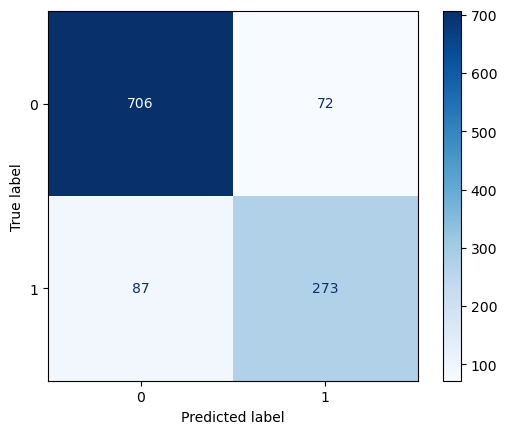

In [58]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

### - Logistic Regression

**Logistic Regression** — это еще один популярный алгоритм классификации. Хотя она в первую очередь используется для бинарной классификации, она также работает эффективно для классификации текста. Логистическая регрессия моделирует вероятность принадлежности к классу (спам или не спам), используя линейную зависимость между признаками и целевой переменной.

После того как обе модели будут обучены, мы сравним их результаты, используя такие метрики, как точность, полнота, точность (precision) и F1-мера. Это сравнение поможет нам понять, какая модель лучше подходит для задачи классификации спама.

In [59]:
from sklearn.linear_model import LogisticRegression

lr_classifier = LogisticRegression(class_weight='balanced', random_state=42)
lr_classifier.fit(X_train_tfidf, y_train)
y_pred_lr = lr_classifier.predict(X_test_tfidf)

# Evaluate the model
print(
    f"Accuracy with Logistic Regression: {accuracy_score(y_test, y_pred_lr):.4f}")
print("Classification Report with Logistic Regression:")
print(classification_report(y_test, y_pred_lr))

Accuracy with Logistic Regression: 0.8647
Classification Report with Logistic Regression:
              precision    recall  f1-score   support

           0       0.92      0.88      0.90       778
           1       0.77      0.82      0.79       360

    accuracy                           0.86      1138
   macro avg       0.84      0.85      0.85      1138
weighted avg       0.87      0.86      0.87      1138



## 7. Сохранение модели

После того как модель обучена и оценена, мы сохраняем как модель, так и векторизатор на диск для последующего использования. Сохранение обученной модели позволяет легко загружать ее в дальнейшем без необходимости повторного обучения.

In [60]:
import pickle

# Save the model to a file
file_name=filename.split('.')[0]
pickle.dump(model,open(f'../reports/{file_name}_classifier.pkl' , 'wb'))
pickle.dump(vectorizer, open(
    f'../reports/{file_name}_vectorizer.pkl', 'wb'))

Для удобства идентификации моделей в будущем мы используем дескриптивные имена файлов, которые отражают тип модели и используемый набор данных. Это позволяет нам легко различать различные версии моделей при работе с несколькими наборами данных или при проведении экспериментов с отравленными данными.

Сохраняя модель и векторизатор, мы можем быстро протестировать их на новых данных, включая отравленные наборы данных, без повторного обучения. Это будет необходимо при тестировании воздействия атак отравления данных в следующих разделах.

### Заключение

На данном этапе мы успешно построили рабочий классификатор спама, используя различные методы предварительной обработки, векторизации и моделирования. В следующих разделах мы сосредоточимся на отравлении данных, когда в набор данных будут внедрены вредоносные данные, чтобы проверить, насколько хорошо модель справляется с атаками. Мы также исследуем различные стратегии защиты от этих атак, чтобы улучшить устойчивость модели.

